# Фаза 2. Неделя 11
## Рекомендательные системы
### Базовый нейросетевой подход 

In [5]:
# !wget -P https://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip -qq aux/ml-100k.zip

In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import torchutils as tu

torch.manual_seed(666)
import os
import time
import mlflow


# эта строка закомментирована, потому что эти
# функции вам предстоит реализовать в сегодняшнем задании
from aux.recommend import *

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CURR_DIR = os.path.dirname("__name__")
CURR_DIR

''

In [9]:
col_names = ["user_id", "item_id", "rating", "timestamp"]
train_df = pd.read_csv("data/u1.base", sep="\t", header=None, names=col_names)
valid_df = pd.read_csv("data/u1.test", sep="\t", header=None, names=col_names)

In [10]:
movie_id = pd.read_csv("data/u.item", sep="|", encoding="iso-8859-1", header=None).iloc[
    :, 0:2
]
movie_id.columns = ["id", "title"]
movie_id["id"] = movie_id["id"]
id_to_movie = dict(zip(movie_id["id"], movie_id["title"]))

In [11]:
train_df[["user_id", "item_id"]] = train_df[["user_id", "item_id"]]
valid_df[["user_id", "item_id"]] = valid_df[["user_id", "item_id"]]

In [12]:
train_df

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


In [13]:
train_df["user_id"].nunique()

943

In [14]:
# Эти данные нужны для эмбеддинг слоев
UNIQUE_USERS = train_df["user_id"].nunique() + 1  # Для слоя Embedding
UNIQUE_MOVIES = len(id_to_movie.items()) + 1  # Для слоя Embedding
print(f"Unique users: {UNIQUE_USERS}, unique movies: {UNIQUE_MOVIES}")

Unique users: 944, unique movies: 1683


In [15]:
display(train_df)
display(valid_df)

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


,user_id,item_id,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
19995,458,648,4,886395899
19996,458,1101,4,886397931
19997,459,934,3,879563639
19998,460,10,3,882912371


In [16]:
class MovieLensDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        user_col: int = 0,
        item_col: int = 1,
        rating_col: int = 2,
    ):

        self.df = df

        self.user_tensor = torch.tensor(
            self.df.iloc[:, user_col].to_numpy(), dtype=torch.long, device=DEVICE
        )
        self.item_tensor = torch.tensor(
            self.df.iloc[:, item_col].to_numpy(), dtype=torch.long, device=DEVICE
        )
        self.trgt_tensor = torch.tensor(
            self.df.iloc[:, rating_col].to_numpy(), dtype=torch.float32, device=DEVICE
        )

    def __len__(self):
        return self.user_tensor.shape[0]
        # return len(self.df)

    def __getitem__(self, index):
        return (
            self.user_tensor[index],
            self.item_tensor[index],
            self.trgt_tensor[index],
        )


BATCH_SIZE = 128
train_dataset = MovieLensDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataset = MovieLensDataset(valid_df)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
class BaseRecNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        # параметры сети
        self.config = config
        self.num_users = config["num_users"]
        self.num_items = config["num_items"]
        self.emb_size = config["emb_size"]
        self.emb_droupout = config["emb_drop"]
        self.dropout = config["lin_drop"]
        self.out_range = config["out_range"]

        # embedding-слои
        self.emb_user = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout),
        )
        self.emb_item = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout),
        )

        self.lin_user = nn.Linear(self.emb_size, self.emb_size)
        self.lin_item = nn.Linear(self.emb_size, self.emb_size)

        # финальный полносвязный слой для пронгоза оценки
        self.head = nn.Sequential(
            nn.Linear(self.emb_size * 2, 512),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, user_idx, item_idx):
        user_emb = F.sigmoid(self.lin_user(self.emb_user(user_idx)))
        item_emb = F.sigmoid(self.lin_item(self.emb_item(item_idx)))
        x = torch.cat([user_emb, item_emb], dim=1)
        # print(x)
        x = torch.sigmoid(self.head(x))  # [0, 1]
        x = x * (self.out_range[1] - self.out_range[0]) + self.out_range[0]
        # x = 1 -> 1 * (5 - 1) + 1 = 5
        # x = 0.1 -> .1 * 4 + 1 = 1.4.int() -> 1
        return x


config = {
    "num_users": UNIQUE_USERS,  # число уникальных пользователей
    "num_items": UNIQUE_MOVIES,  # число уникальных филмьов
    "emb_size": 16,  # размер эмбеддинга
    "emb_drop": 0.05,  # параметр для слоя эмбеддинга
    "lin_drop": 0.5,  # dropout head layer
    "out_range": [1.0, 5.0],  # для нормировки выходных оценок
}
model = BaseRecNet(config)

In [18]:
# посмотрим, что нам возвращает data loader
test_batch = next(iter(train_loader))
print(
    f"""test_batch content:
[user_id, user_id, ...]   -> {test_batch[0]}
[movie_id, movie_id, ...] -> {test_batch[1]}
[rating, rating, ...]     -> {test_batch[2]}
"""
)

# отправим в модель и посмотрим на выход
model.to(DEVICE)(test_batch[0].to(DEVICE), test_batch[1].to(DEVICE))[:10]

test_batch content:
[user_id, user_id, ...]   -> tensor([519, 479, 606, 291, 772, 840, 535,  92, 896, 139, 704, 326, 670, 181,
        894, 488, 716, 334, 716,  96, 184, 230, 307, 315, 716, 346, 352, 401,
        710,   7, 642, 487, 308, 276, 709, 632, 307, 590,  49, 550, 151, 542,
        880, 735, 541, 561, 508, 542, 938, 416, 276, 794, 178, 654,  49, 588,
         58, 788, 535, 861, 855, 303, 424, 557, 796, 840, 212, 299, 497, 219,
        186, 474, 640, 363, 452, 416, 826, 846, 181, 798, 933, 445, 601, 693,
        588, 524, 618, 796, 363, 367, 886, 854, 932, 711, 557, 698, 459, 863,
         15, 787, 561, 618, 144, 301,  26, 577, 504, 589,  83, 186, 201, 653,
        757, 457, 774, 328, 553, 224, 712, 568, 880, 343, 677, 402, 479, 251,
        554, 889], device='cuda:0')
[movie_id, movie_id, ...] -> tensor([ 748,  168, 1055,  563,  294, 1674, 1136,   58,  820,  460,  497,    9,
         650,  107,  279,  238,  131, 1198,  527,  216,  813,   99,  204,  288,
          31,  156,  653

tensor([[2.8621],
        [3.0797],
        [2.5910],
        [2.9484],
        [2.8387],
        [3.0037],
        [2.9769],
        [2.8668],
        [2.6271],
        [2.5798]], device='cuda:0', grad_fn=<SliceBackward0>)

In [19]:
tu.get_model_summary(model, user_idx=test_batch[0], item_idx=test_batch[1])

Layer                      Kernel       Output     Params       FLOPs
0_emb_user.Embedding_0    [16, 944]    [128, 16]   15,104         128
1_emb_user.Dropout_1              -    [128, 16]        0           0
2_lin_user                 [16, 16]    [128, 16]      272      63,488
3_emb_item.Embedding_0   [16, 1683]    [128, 16]   26,928         128
4_emb_item.Dropout_1              -    [128, 16]        0           0
5_lin_item                 [16, 16]    [128, 16]      272      63,488
6_head.Linear_0           [32, 512]   [128, 512]   16,896   4,128,768
7_head.Dropout_1                  -   [128, 512]        0           0
8_head.ReLU_2                     -   [128, 512]        0           0
9_head.Linear_3            [512, 1]     [128, 1]      513     130,944
Total params: 59,985
Trainable params: 59,985
Non-trainable params: 0
Total FLOPs: 4,386,944 / 4.39 MFLOPs
---------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB)

In [20]:
criterion = lambda preds, target: F.smooth_l1_loss(preds, target, beta=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
history = {"epoch_train_losses": [], "epoch_valid_losses": []}

In [22]:
def fit_model(n_epochs: int = 10, history: dict = history) -> dict:

    history = history or {"epoch_train_losses": [], "epoch_valid_losses": []}

    for i in tqdm(range(n_epochs)):
        batch_losses = []
        model.train()
        for user, item, rating in train_loader:
            preds = model(user, item)
            loss = criterion(preds.squeeze(-1), rating)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        history["epoch_train_losses"].append(np.mean(batch_losses))

        model.eval()

        batch_losses = []
        for user, item, rating in valid_loader:
            preds = model(user, item)
            loss = criterion(preds.squeeze(-1), rating)
            batch_losses.append(loss.item())

        history["epoch_valid_losses"].append(np.mean(batch_losses))
    return history

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

CPU times: user 1min 14s, sys: 394 ms, total: 1min 15s
Wall time: 1min 9s


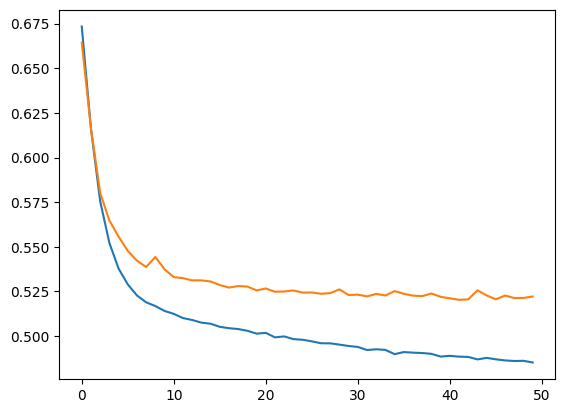

In [23]:
%%time
log = fit_model(50, history)
plt.plot(history['epoch_train_losses'])
plt.plot(history['epoch_valid_losses'])

### Задание 1


Создай файл `recommend.py` в папке `aux` и реализуй в нем 2 функции: 
   
1. __recommend_for_user_id_from_valid__

    Функция принимает на вход идентификатор пользователя, делает по нему выборку из валидационной части, 
    затем прогнозирует рейтинги для тех фильмов, которым пользователь поставил оценку. 
    Результат работы функции – датафрейм: 

    | movie_id | title | pred_rating | true_rating | 
    |----------|-------|-------------|-------------|


    ```python
    (function) def recommend_for_user_id_from_valid

    Returns dataframe top n movies, true and pred ratings 

        Args:
            user_id (int): user_id for predictions
            valid_df (pd.DataFrame): valid dataframe
            model (torch.nn.Module): neural net
            n (int, optional): top_n movies will be returned. Defaults to 10..

        Returns:
            pd.DataFrame: with 4 cols: movie_id, title, pred_rating, true_rating
            shape(n, 4)
        
    ```



In [24]:
display(valid_df)

,user_id,item_id,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
19995,458,648,4,886395899
19996,458,1101,4,886397931
19997,459,934,3,879563639
19998,460,10,3,882912371


In [70]:
recs = recommend_for_user_id_from_valid(100, valid_df, model, DEVICE, id_to_movie, -1)
recs

,movie_id,title,pred_rating,rating
5046,313,Titanic (1997),4.628908,5
5045,302,L.A. Confidential (1997),4.467899,4
5047,316,As Good As It Gets (1997),4.383108,5
5059,750,Amistad (1997),3.983524,4
5041,268,Chasing Amy (1997),3.967540,3
5053,344,"Apostle, The (1997)",3.782803,4
5051,340,Boogie Nights (1997),3.769402,3
5044,292,Rosewood (1997),3.623472,2
5050,333,"Game, The (1997)",3.478734,3
5063,1236,"Other Voices, Other Rooms (1997)",3.446271,3


2. __recommend_for_user_id_unwatched__


    ```python
    (function) recommend_for_user_id_unwatched

    Return DataFrame with sorted by pred_rating among unwatched films

        Args:
            user_id (int): user_id for recommedations 
            full_df (pd.DataFrame): full dataframe
            id_to_movie (dict): dict with id and corresponding movie title

        Returns:
            pd.DataFrame: shape (n_unwatched_movies, 2) with predicted rating and movie title
    ```

In [99]:
full_df = pd.concat([train_df, valid_df], axis=0)
display(full_df.head())
display(full_df.shape)

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


(100000, 4)

In [78]:
# tempdf = pd.DataFrame(id_to_movie)
# tempdf

In [102]:
recommend_unwatched, num_watched, num_unwatched = recommend_for_user_id_unwatched(
    user_id=100,
    full_df=pd.concat([train_df, valid_df], axis=0),
    id_to_movie=id_to_movie,
    model=model,
    device=DEVICE,
    n=-1,
)
display(recommend_unwatched)
print(num_watched, num_unwatched)

,movie_id,title,pred_rating
375,408,"Close Shave, A (1995)",4.821389
299,318,Schindler's List (1993),4.782478
168,169,"Wrong Trousers, The (1993)",4.775221
1407,1467,"Saint of Fort Washington, The (1993)",4.774426
1389,1449,Pather Panchali (1955),4.772922
...,...,...,...
1033,1087,Bloodsport 2 (1995),1.140383
1190,1250,Best of the Best 3: No Turning Back (1995),1.130002
1186,1246,Bushwhacked (1995),1.124761
1227,1287,Ed (1996),1.124711


59 1682


Сохрани файл на `github`

### Задание 2

Реализуй функции для вычисления метрики **precision@k** и **recall@k**. 
https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54 

In [ ]:
def precision_k(actual_ratings: list, pred_ratings: list, k: int) -> float:
    ...
    return precision_k


def recall_k(actual_ratings: list, pred_ratings: list, k: int) -> float:
    ...
    return recall

### Задание 3 

Вычисли средний precision и recall для всех пользователей: присутствующих в обучающей и валидационных выборках.

In [ ]:
def compute_total_metrics(valid_df):
    pass
    return total_precision, total_recall

### Задание 4

Используй увеличенную версию датасета: обучи модель, сравни метрики с получившимися выше. 

```
!wget -O data/ml25.zip --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip -qq data/ml25.zip
```